In [1]:
import gym
import kino_envs
import numpy as np
import matplotlib.pyplot as plt

## Differential Drive

The differential drive is an 2D mobile robot. Its state is $[x, y, \theta, v, \omega]$ the 2D coordinates, the yaw angle, the speed and the angular velocity. The control is $[a_v, a_{\omega}]$, the derivative of the speed and the angular velocity. Its dynamics is

$$\begin{bmatrix}
\dot{x}\\ 
\dot{y}\\ 
\dot{\theta}\\ 
\dot{v}\\ 
\dot{\omega}
\end{bmatrix}
=
\begin{bmatrix}
v\cos(\theta)\\ 
v\sin(\theta)\\ 
\omega\\ 
a_v\\ 
a_{\omega}
\end{bmatrix}$$

The task for the robot is to reach the goal region. For reinforcement learning, its observation is 3-folder, including the current state, the acchieved goal and the desired goal. The reward is $1$ if it reaches the goal region, $-0.1$ otherwise.



observation space: Dict(achieved_goal:Box(2,), desired_goal:Box(2,), state:Box(5,))

action space: Box(2,)


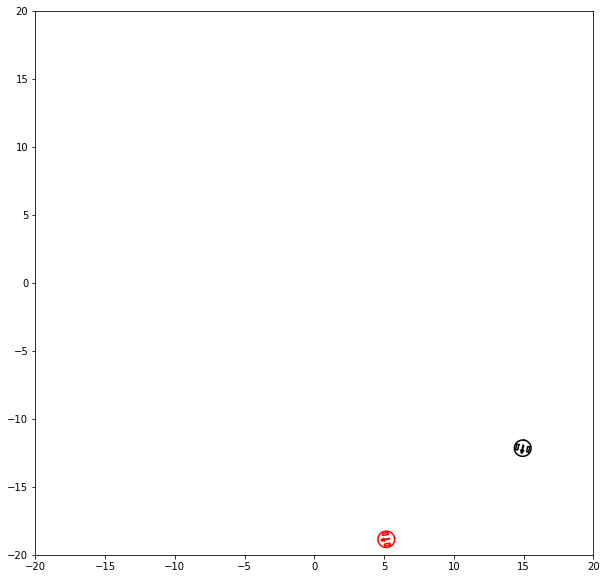

In [2]:
env = gym.make('DifferentialDrive-v0')
print(f'observation space: {env.observation_space}')
print()
print(f'action space: {env.action_space}')
env.reset()
env.render()

## Differential Drive Obstacle

Compared to above, obstacles are added in the environment. The robot needs to avoid collision while run towards the goal. The observation is 4-folder: in addition to the state, the acchieved goal and the desired goal, the agent senses the surrounding environment by a local map. The map indicates the occupancy area, the free area and the robot body via different pixel values. The reward is $-2$ if the robot is in collision, $1$ for goal reaching, $-0.1$ otherwise.



observation space: Dict(achieved_goal:Box(2,), desired_goal:Box(2,), local_map:Box(101, 101, 1), state:Box(5,))

action space: Box(2,)


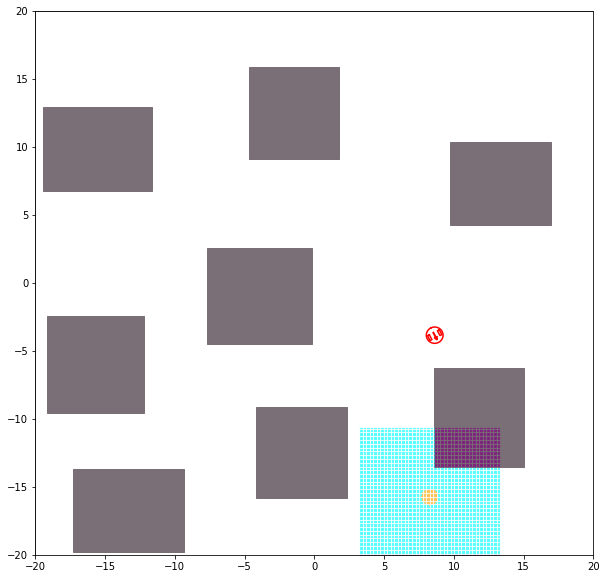

In [3]:
env = gym.make('DifferentialDriveObs-v0')
print(f'observation space: {env.observation_space}')
print()
print(f'action space: {env.action_space}')
env.reset()
env.render('local_map')

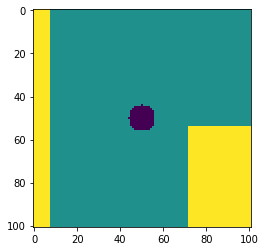

In [4]:
# show the local map
obs = env.get_obs()
img = obs['local_map']
img = img.reshape((img.shape[:2]))
plt.imshow(img)